In [36]:
# Install MNE library (if not already installed)
!pip install mne

# Import necessary libraries
import numpy as np
import scipy.io
import mne
import matplotlib.pyplot as plt
from google.colab import drive


In [37]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


# Load the Data
data_path = "/content/drive/MyDrive/EEG dataset/Subject_A_Train.mat"
data = scipy.io.loadmat(data_path)
print(data.keys())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
dict_keys(['__header__', '__version__', '__globals__', 'Signal', 'TargetChar', 'Flashing', 'StimulusCode', 'StimulusType'])


In [38]:
# 3. Extract & Reshape EEG Signal

# Extract raw EEG signal
signal = data['Signal']

epochs, samples, channels = signal.shape
signal_2d = signal.reshape(epochs * samples, channels)
signal_2d = signal_2d.T
signal_2d = signal_2d * 1e-6

print("Reshaped EEG signal shape (channels, total_samples):", signal_2d.shape)


Reshaped EEG signal shape (channels, total_samples): (64, 662490)


In [39]:
# 4. Process Marker Channels (Flashing & StimulusCode)

# Extract marker channels
flashing = data['Flashing']
stimulus_code = data['StimulusCode']
flashing_1d = flashing.reshape(-1)
stimulus_code_1d = stimulus_code.reshape(-1)
total_samples = signal_2d.shape[1]

assert flashing_1d.shape[0] == total_samples, "Flashing length does not match EEG signal"
assert stimulus_code_1d.shape[0] == total_samples, "StimulusCode length does not match EEG signal"

print("Flashing marker length:", flashing_1d.shape)
print("StimulusCode marker length:", stimulus_code_1d.shape)
print("EEG total samples:", total_samples)


Flashing marker length: (662490,)
StimulusCode marker length: (662490,)
EEG total samples: 662490


In [40]:
# 5. Construct MNE Events

# Detect event onsets using rising edges of the Flashing signal
flashing_diff = np.diff(flashing_1d, prepend=0)
onset_indices = np.where(flashing_diff == 1)[0]
event_ids = stimulus_code_1d[onset_indices].astype(int)
events = np.column_stack((onset_indices,
                           np.zeros(len(onset_indices), dtype=int),
                           event_ids))

print("Events array shape:", events.shape)
print("First 10 events:\n", events[:10])


Events array shape: (15300, 3)
First 10 events:
 [[  0   0  12]
 [ 42   0  11]
 [ 84   0   3]
 [126   0  10]
 [168   0   9]
 [210   0   7]
 [252   0   8]
 [294   0   2]
 [336   0   6]
 [378   0   5]]


In [41]:
# 6. Create MNE Raw Object

# Define sampling frequency (Hz)
sfreq = 240
n_channels = signal_2d.shape[0]
ch_names = [f"EEG{i+1}" for i in range(n_channels)]
ch_types = ["eeg"] * n_channels

# Create MNE info object
info = mne.create_info(ch_names=ch_names,
                       sfreq=sfreq,
                       ch_types=ch_types)

# Create Raw object from EEG data
raw = mne.io.RawArray(signal_2d, info)
stim_data = flashing_1d[np.newaxis, :]
stim_info = mne.create_info(ch_names=["STIM"],
                            sfreq=sfreq,
                            ch_types=["stim"])

stim_raw = mne.io.RawArray(stim_data, stim_info)
raw.add_channels([stim_raw], force_update_info=True)

print(raw)


Creating RawArray with float64 data, n_channels=64, n_times=662490
    Range : 0 ... 662489 =      0.000 ...  2760.371 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=662490
    Range : 0 ... 662489 =      0.000 ...  2760.371 secs
Ready.
<RawArray | 65 x 662490 (2760.4 s), ~328.6 MiB, data loaded>


Effective window size : 8.533 (s)
Plotting power spectral density (dB=True).


/tmp/ipython-input-4186718254.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  psd.plot()


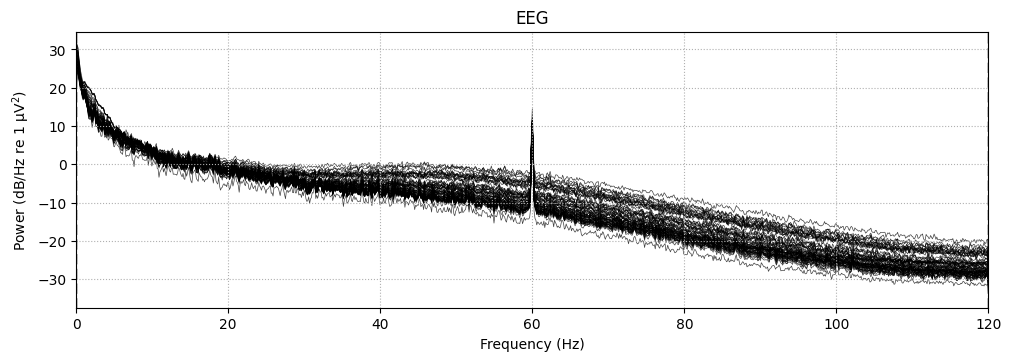

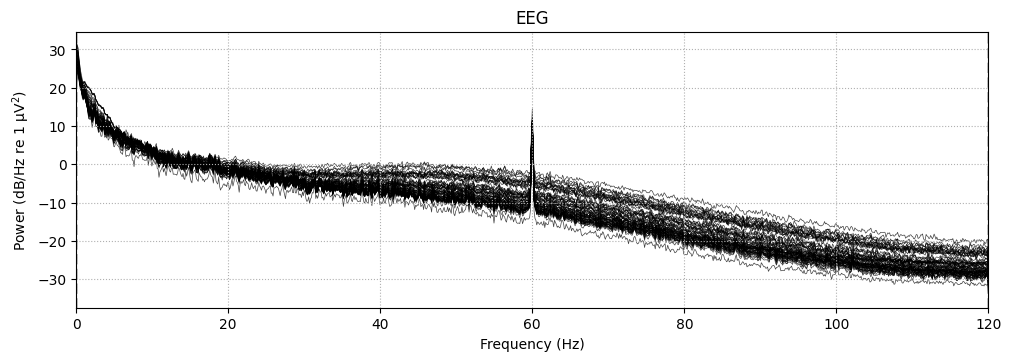

In [42]:
# 1: Visualize Data BEFORE Filtering (Power Spectral Density)
psd = raw.compute_psd()
psd.plot()


In [43]:
# 2: Apply Band-pass Filter (0.1 Hz – 20 Hz)
raw_filt = raw.copy()

# Apply band-pass FIR filter
raw_filt.filter(l_freq=0.1,
                h_freq=20.0,
                fir_design='firwin')

print("Band-pass filtering applied (0.1–20 Hz).")


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 7921 samples (33.004 s)

Band-pass filtering applied (0.1–20 Hz).


In [44]:
# Part 3: Downsample the Data
raw_filt_resampled = raw_filt.copy()
raw_filt_resampled.resample(sfreq=120)

print("Data downsampled to 120 Hz.")


Finding events on: STIM
Trigger channel STIM has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
15299 events found on stim channel STIM
Event IDs: [1]
Finding events on: STIM
Trigger channel STIM has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
15299 events found on stim channel STIM
Event IDs: [1]
Data downsampled to 120 Hz.


Effective window size : 17.067 (s)
Plotting power spectral density (dB=True).


/tmp/ipython-input-602658134.py:4: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  psd_after.plot()


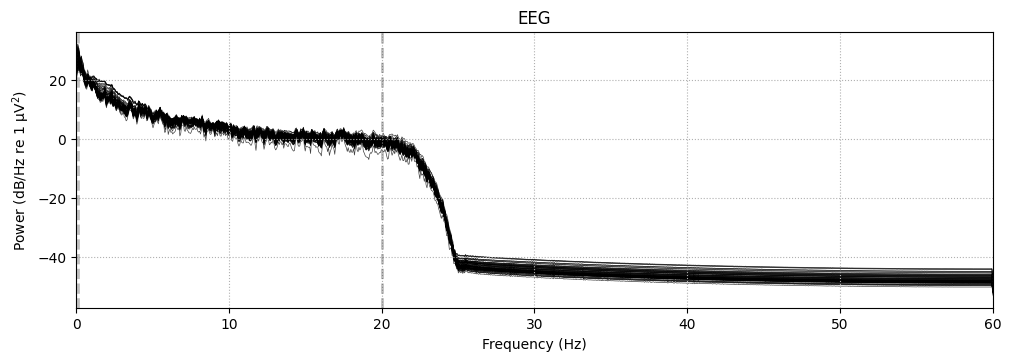

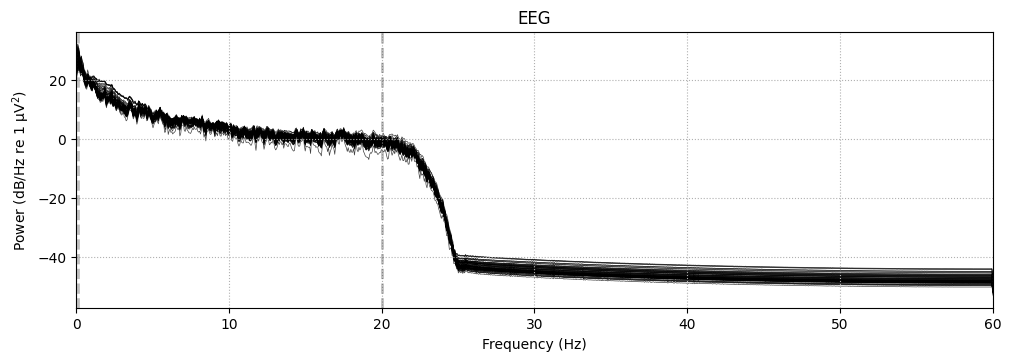

In [45]:
# 4: Visualize Data AFTER Filtering and Downsampling (Power Spectral Density)

psd_after = raw_filt_resampled.compute_psd()
psd_after.plot()


In [46]:
# 1: Assign Standard Channel Names and Montage

standard_ch_names = [
    'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8',
    'FC5', 'FC1', 'FC2', 'FC6',
    'T7', 'C3', 'Cz', 'C4', 'T8',
    'CP5', 'CP1', 'CP2', 'CP6',
    'P7', 'P3', 'Pz', 'P4', 'P8',
    'O1', 'O2'
]
raw_filt_resampled.rename_channels(
    {old: new for old, new in zip(raw_filt_resampled.ch_names[:-1], standard_ch_names)}
)
montage = mne.channels.make_standard_montage('standard_1020')

raw_filt_resampled.set_montage(
    montage,
    match_case=False,
    on_missing='ignore'
)


<RawArray | 65 x 331245 (2760.4 s), ~164.3 MiB, data loaded>

In [47]:
# 2: Initialize and Fit ICA

raw_ica = raw_filt_resampled.copy()
raw_ica.filter(l_freq=1.0, h_freq=None)
ica = ICA(
    n_components=20,
    random_state=42,
    method='fastica'
)
ica.fit(raw_ica, picks='eeg')

print("ICA fitting completed successfully.")


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 397 samples (3.308 s)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 51.3s.
ICA fitting completed successfully.


Creating RawArray with float64 data, n_channels=20, n_times=331245
    Range : 0 ... 331244 =      0.000 ...  2760.367 secs
Ready.


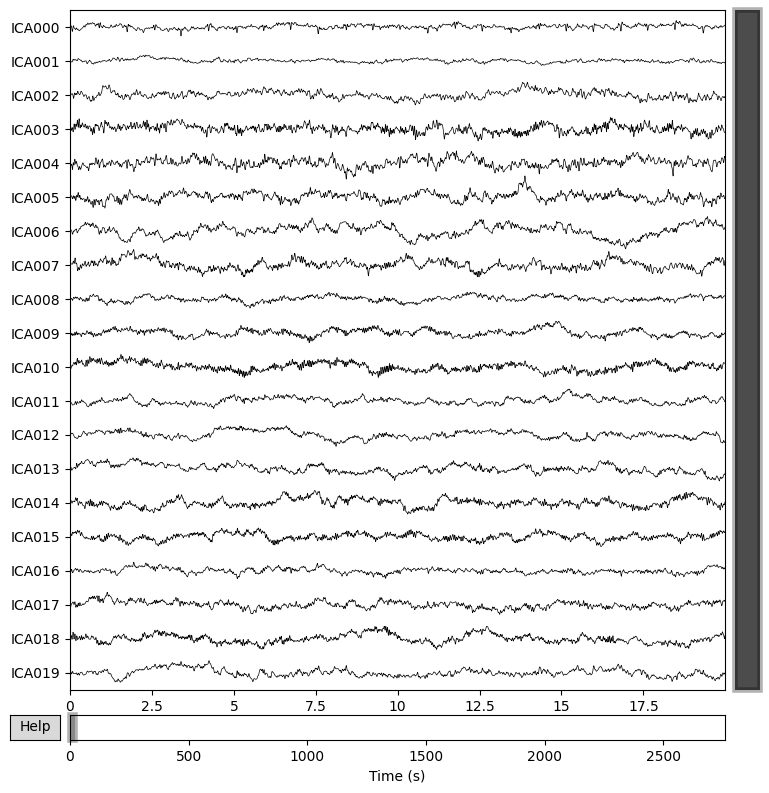

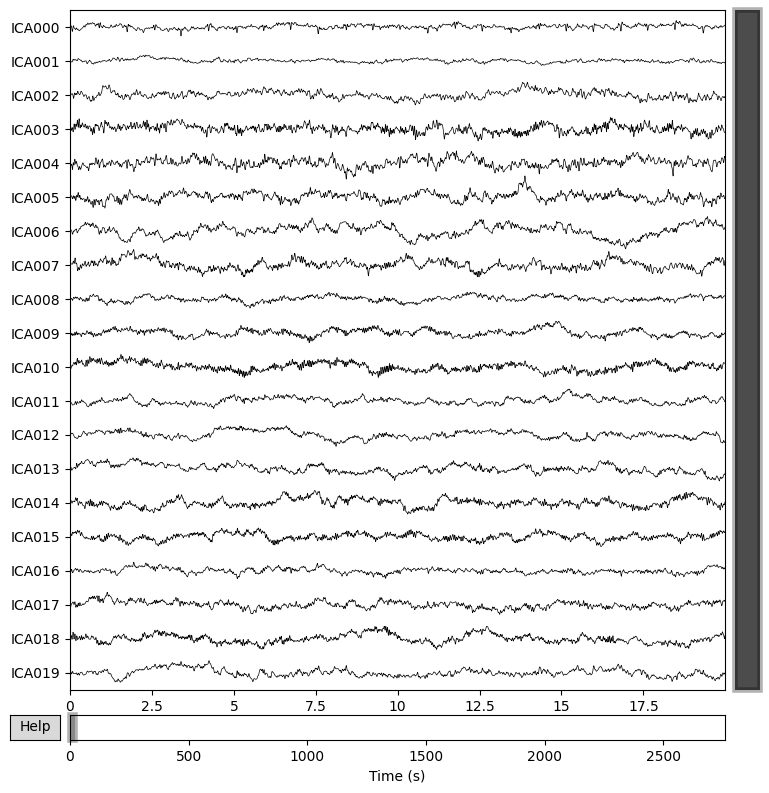

In [48]:
# 3: Plot ICA Component Time Series (Safe for Missing Channel Locations)

ica.plot_sources(raw_filt_resampled)


In [49]:
# 1: Prepare Events for Epoching

stimulus_type = data['StimulusType']
stimulus_type_1d = stimulus_type.reshape(-1)

event_labels = stimulus_type_1d[onset_indices].astype(int) + 1

events_epoching = np.column_stack((
    onset_indices,
    np.zeros(len(onset_indices), dtype=int),
    event_labels
))

print("Epoching events shape:", events_epoching.shape)
print("Unique event IDs:", np.unique(events_epoching[:, 2]))


Epoching events shape: (15300, 3)
Unique event IDs: [1 2]


In [50]:
# 2: Define Event IDs Dictionary

event_id = {
    'Non-Target': 1,
    'Target': 2
}

print("Event ID dictionary:", event_id)


Event ID dictionary: {'Non-Target': 1, 'Target': 2}


In [51]:
# 3: Create Epochs

tmin = -0.2
tmax = 0.8

epochs = mne.Epochs(
    raw_filt_resampled,
    events=events_epoching,
    event_id=event_id,
    tmin=tmin,
    tmax=tmax,
    baseline=(None, 0),
    preload=True,
    picks='eeg'
)

print(epochs)


Not setting metadata
15300 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 15300 events and 121 original time points ...
7650 bad epochs dropped
<Epochs | 7650 events (all good), -0.2 – 0.8 s (baseline -0.2 – 0 s), ~452.0 MiB, data loaded,
 'Non-Target': 6375
 'Target': 1275>


In [52]:
# 4: Compute Evoked Responses

evoked_target = epochs['Target'].average()
evoked_nontarget = epochs['Non-Target'].average()

print("Evoked response (Target):", evoked_target)
print("Evoked response (Non-Target):", evoked_nontarget)


Evoked response (Target): <Evoked | 'Target' (average, N=1275), -0.2 – 0.8 s, baseline -0.2 – 0 s, 64 ch, ~123 KiB>
Evoked response (Non-Target): <Evoked | 'Non-Target' (average, N=6375), -0.2 – 0.8 s, baseline -0.2 – 0 s, 64 ch, ~123 KiB>


combining channels using "mean"
combining channels using "mean"


/tmp/ipython-input-2508781596.py:3: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(


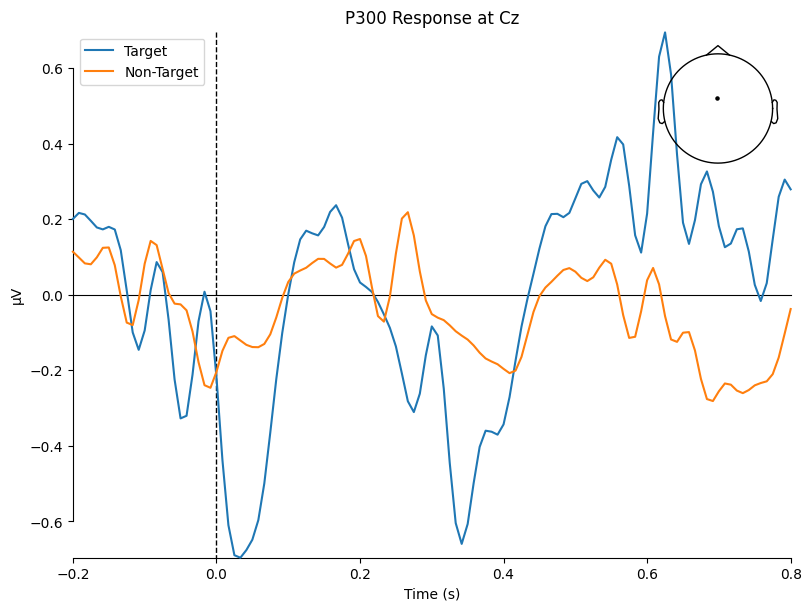

[<Figure size 800x600 with 2 Axes>]

In [53]:
# 5: Visualize the P300 Response

mne.viz.plot_compare_evokeds(
    {'Target': evoked_target, 'Non-Target': evoked_nontarget},
    picks='Cz',
    combine='mean',
    title='P300 Response at Cz'
)


combining channels using "mean"
combining channels using "mean"


/tmp/ipython-input-3269608504.py:3: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(


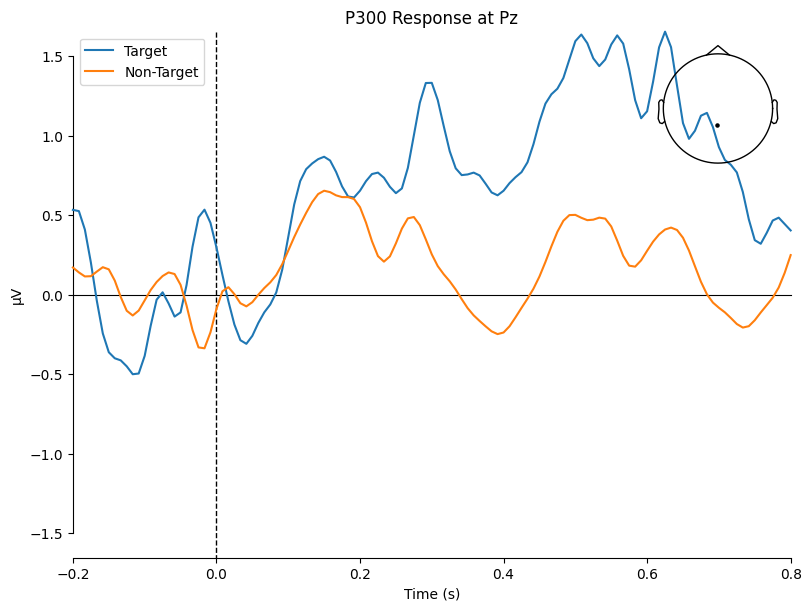

[<Figure size 800x600 with 2 Axes>]

In [54]:
# 1. Compare Evokeds at Pz

mne.viz.plot_compare_evokeds(
    {'Target': evoked_target, 'Non-Target': evoked_nontarget},
    picks='Pz',
    combine='mean',
    title='P300 Response at Pz'
)
